# **Instalacion de Programas**


In [1]:
#Instalacion SAM
!pip install -q opencv-python matplotlib latextable optuna
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'


# Descargar Imagenes para Sam
#!mkdir images
!wget -q -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -q -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#Root Necesario para SAM
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
#Instalacion de Seg-Metrics
!pip install seg-metrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=b254e3beb1817b4a89e6765e4c2db164275e5847c56e0feabc227ba8e9427f29
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


# **Importar Librerias**

In [4]:
import sys

#Librerias de Pytorch y Array Handling
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import pandas as pd

#Carga de imagenes
from PIL import Image
import os
import scipy.ndimage
from google.colab import drive

#Graficas
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Procesamiento de Texto
from tabulate import tabulate
from texttable import Texttable
import latextable

#Estadistica
import statistics
import math
import time
import cv2
import statistics
from scipy.stats import skew
from scipy.stats import probplot
from scipy.stats import kurtosis
from scipy.stats import kstest
from scipy import stats
from sklearn.model_selection import train_test_split
import seg_metrics.seg_metrics as sg



```
# This is formatted as code
```

# **Definición de funciones para procesamiento y conversion de Imagenes**

In [5]:

def open_image(pImagePath):
    '''
    Creates a tensor with image grayscale values from 0 to 255.
    @param pImagePath: A string with the image path.
    @return: A tensor.
    '''
    return torch.from_numpy(np.array(Image.open(pImagePath).convert('L')))


def open_hsv_image(pImagePath):
    '''
    Creates a tensor with image grayscale values from 0 to 255.
    @param pImagePath, a string with the image path.
    @return, a tensor.
    '''
    image = cv2.imread(pImagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return torch.from_numpy(image)


def show_image(U, title, subtitle, vmin = 0, vmax = 255):
    '''
    Creates a plot with the image, title and subtitle.
    @param U, is a tensor with the image.
    @param title, a string with the content of the title.
    @param subtitle, a string with the content of the subtitle.
    @param vmin, the minimum range value in the grayscale that will be showed.
        for example, if vmin = 5 and got 0, 5 will be showed instead of 0.
    @param vmiax, the maximum range value in the grayscale that will be showed.
        for example, if vmax = 150 and got 255, 150 will be showed instead of 255.
    @return, None
    '''
    plt.rcParams["axes.grid"] = False
    plt.figure()
    plt.imshow(U, cmap = plt.get_cmap("gray"), vmin = vmin, vmax = vmax)
    plt.suptitle(title, y=1.05, fontsize=18)
    plt.title(subtitle, fontsize=10)


# Programar para crear tablas LaTeX desde python
def create_LaTeX_table(rows, caption = ""):
    '''
    Creates a table in LaTeX format given a matrix (list of rows).
    @param rows, a matrix with rows of one dimension. The first row
        contains the headers of each column.
    @param caption, a string to add a caption in the botton of the table.
    @return table, a string with the table in LaTeX format code.
    '''
    table = Texttable()
    table.set_cols_align(["c"] * len(rows[0]))
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(rows)
    table = latextable.draw_latex(table, caption=caption)
    print('\nTexttable Latex:')
    print(table)
    return table


def dice_coefficient(groundtruth_img, segmented_img):
    '''
    Gives a value with the dice metric, 2*intersection/A+B, A and B being imgs
    @groundtruth_img, the manually segmented image.
    @segmented_img, the new sewgmented image predicted.
    '''
    intersection = np.logical_and(groundtruth_img.astype(bool), segmented_img.astype(bool))
    intersection_sum = np.sum(intersection)
    groundtruth_sum = np.sum(groundtruth_img.astype(bool))
    segmented_sum = np.sum(segmented_img.astype(bool))
    dice = (2.0 * intersection_sum) / (groundtruth_sum + segmented_sum)
    return dice

def jaccard_similarity(groundtruth_img, segmented_img):
    '''
    Gives a value with the jaccard metric, ∩(A,B)/ A+B - ∩(A,B), A and B being imgs
    @groundtruth_img, the manually segmented image.
    @segmented_img, the new sewgmented image predicted.
    '''
    intersection = np.logical_and(groundtruth_img.astype(bool), segmented_img.astype(bool))
    intersection_sum = np.sum(intersection)
    groundtruth_sum = np.sum(groundtruth_img.astype(bool))
    segmented_sum = np.sum(segmented_img.astype(bool))
    jaccard = intersection_sum / (groundtruth_sum + segmented_sum - intersection_sum)
    return jaccard

def precision_recall_f1_accuracy(groundtruth_img, segmented_img):
    '''
    Gives a tuple with metrics as precision, recall, f1, accuracy that depends on the
    confusion matrix
    @groundtruth_img, the manually segmented image.
    @segmented_img, the new sewgmented image predicted.
    '''
    groundtruth_img = groundtruth_img.astype(bool)
    segmented_img = segmented_img.astype(bool)
    true_positive = np.sum(groundtruth_img & segmented_img)
    true_negative = np.sum(~groundtruth_img & ~segmented_img)
    false_positive = np.sum(~groundtruth_img & segmented_img)
    false_negative = np.sum(groundtruth_img & ~segmented_img)
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*((precision*recall/precision+recall))
    accuracy = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
    return (precision, recall, f1, accuracy)

def recortar_imagen(imagen, ancho_borde):
    # Leer la imagen
    img = cv2.imread(imagen)

    # Obtener las dimensiones de la imagen
    alto, ancho, _ = img.shape

    # Definir las coordenadas del recorte
    x1 = ancho_borde
    y1 = ancho_borde
    x2 = ancho - ancho_borde
    y2 = alto - ancho_borde

    # Recortar la imagen
    img_recortada = img[y1:y2, x1:x2]

    return img_recortada


#Binarizacion de la imagen en escala de grises
def binarize_image(image):
    '''
    '''
    binarized_image = np.copy(image)
    show_image(image, "Original image", "")
    for i in range(binarized_image.shape[0]):
        for j in range(binarized_image.shape[1]):
            if binarized_image[i, j] <= 60:
                binarized_image[i, j] = 0.0  # Tono oscuro
            else:
                binarized_image[i, j] = 1.0  # Blanco


    binarized_image = scipy.ndimage.binary_fill_holes(binarized_image.astype(int)).astype(float)
    return binarized_image

#Graficar valores resultantes en un histograma
def plot_histogram(image):
    '''
    Plots a histogram for the HSV image.
    @param image: An HSV image array.
    '''
    hue_channel = image[:, :, 0].flatten()
    saturation_channel = image[:, :, 1].flatten()
    value_channel = image[:, :, 2].flatten()

    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.hist(hue_channel, bins=180, range=[0, 0.0001], color='r')
    plt.title('Hue Histogram')
    plt.xlabel('Hue Value')
    plt.ylabel('Pixel Count')

    plt.subplot(3, 1, 2)
    plt.hist(saturation_channel, bins=256, range=[0, 0.0001], color='g')
    plt.title('Saturation Histogram')
    plt.xlabel('Saturation Value')
    plt.ylabel('Pixel Count')

    plt.subplot(3, 1, 3)
    plt.hist(value_channel, bins=256, range=[0, 50], color='b')
    plt.title('Value Histogram')
    plt.xlabel('Value')
    plt.ylabel('Pixel Count')

    plt.tight_layout()
    plt.show()


def plot_grayscale_histogram(image):
    '''
    Plots a histogram for the grayscale image.
    @param image: A grayscale image array.
    '''
    plt.figure(figsize=(8, 6))
    plt.hist(image.flatten(), bins=256, range=[0, 60], color='gray')
    plt.title('Grayscale Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Pixel Count')
    plt.show()


def binarize_image_hsv(image):
    binarized_image = np.copy(image)
    for i in range(binarized_image.shape[0]):
        for j in range(binarized_image.shape[1]):
            hue = binarized_image[i, j, 0]
            saturation = binarized_image[i, j, 1]
            value = binarized_image[i, j, 2]

            if hue <= 5:  # Adjust this threshold as per your requirement
                binarized_image[i, j] = [0, 0, 0]  # Tono oscuro (Black)
            else:
                binarized_image[i, j] = [255, 255, 255]  # Blanco (White)
    return binarized_image


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# **Carga de Datasets: Ground Truth y Glioblastoma**


In [6]:
# Accesar al Drive
drive.mount('/content/drive')
groundtruth_images_path = '/content/drive/MyDrive/Trabajo_Practico_2/DATASET_GLIOBLASTOMA/Groundtruth/'
original_images_path = '/content/drive/MyDrive/Trabajo_Practico_2/DATASET_GLIOBLASTOMA/Original/'


path_image_ground_truth = groundtruth_images_path + "C4_02_1_1_DAPI_200_overlay.png"

#Crear funcion para cargar el ground truth
def load_ground_truth_image(path_image_ground_truth):
  grayscale_groundtruth = binarize_image(open_image(path_image_ground_truth))
  return grayscale_groundtruth


Mounted at /content/drive


# **Creación del Modelo de Kittler (Tratamiento A)**

## **Función para calcular los momentos estadisticos**

In [7]:
#funcion para obtener el histograma normalizado de una funcion de densidad
def obtener_histogram_Norm(p):
# Se obtiene la frecuencia y los valores unicos en 2 variables
    Unique, b = torch.unique(p, return_counts=True)
    quantity= p.numel()
#Se normaliza el conteo de valores dividiendolo entre el total de valores obtenidos
    count_norm=b/quantity
    return Unique,count_norm

In [8]:
def calcular_momentos_estadisticos(T,p):
    unique,norm = obtener_histogram_Norm(p)
    p = torch.stack((unique,norm),1).float()
#Divide el tensor en de acuerdo a al punto T
    P1_T = p[torch.where(p[:,0]<T)]
    P2_T = p[torch.where(p[:,0]>=T)]
#Calculo de P
    P1 = sum(P1_T[:,1])
    P2 = sum(P2_T[:,1])
#Calculo de u usando la producto punto para matrices
    u1 = torch.dot(P1_T[:,0],P1_T[:,1])
    u2 = torch.dot(P2_T[:,0],P2_T[:,1])
    u1= u1/P1
    u2 = u2/P2
#Calculo de sigma usando la ecuacion de sigma y producto punto
    s1 = torch.dot(P1_T[:,1],((P1_T[:,0]-u1)**2))
    s2 = torch.dot(P2_T[:,1],((P2_T[:,0]-u2)**2))
    s1 = s1/P1
    s2=s2/P2
    return P1_T,P2_T,P1,P2,u1,u2,s1,s2


## **Función calcular_costo_J(T)**

In [9]:
#Funcion calcula parte de la formula del costo
def conditional_probability(p,P,u,s):
    return (((p-u)/s)**2)+2*math.log10(s)-2*math.log10(P)

#funcion que calcula el costo usando matrices y devuelve J
def calcular_costo_J(T,p):
    P1_T,P2_T,P1,P2,u1,u2,s1,s2 = calcular_momentos_estadisticos(T,p)
    J = torch.dot(P1_T[:,1],conditional_probability(P1_T[:,0],P1,u1,s1))\
    +torch.dot(P2_T[:,1],conditional_probability(P2_T[:,0],P2,u2,s2))
    return J

## **Función princial de Kittler**

In [10]:
def segment_image_kittler(path):
    Imagen=torch.tensor(np.array(Image.open(path).convert('L')))

    unique_elements,counts_norm=obtener_histogram_Norm(Imagen)
    # Inicializar variables
    mejores_costos = []
    mejores_ts = []

    # Calcular los costos para cada umbral candidato
    for i in range(2,(len(unique_elements)-1)):

        T=unique_elements[i]
        costo = calcular_costo_J(T,Imagen)

        mejores_costos.append(costo)
        mejores_ts.append(T)

    # Encontrar el umbral óptimo con el menor costo

    indice_min_costo = np.argmin(mejores_costos)
    T_optimo = mejores_ts[indice_min_costo]


    # Umbralizar la imagen
    umbralizada = np.where(Imagen <=  T_optimo, 0, 1).astype(np.uint8)


    return umbralizada




## **Prueba de funcionamiento con una imagen**

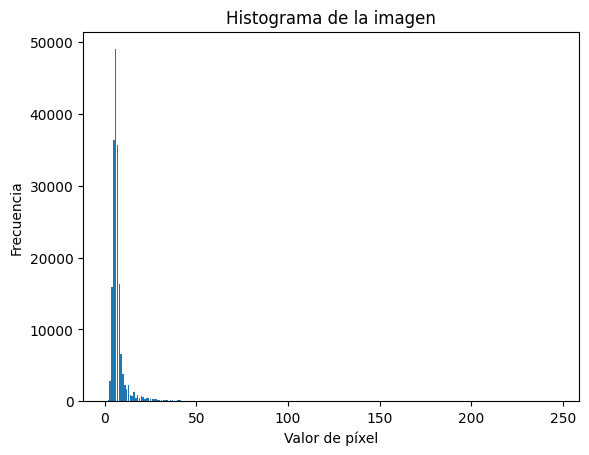

In [11]:
path_image_original = original_images_path + "D4_02_1_1_DAPI_577.png"
Imagen=torch.tensor(np.array(Image.open(path_image_original).convert('L')))
valores, conteos = torch.unique(Imagen, return_counts=True)

# Crea el histograma
plt.bar(valores, conteos)
# Personaliza el gráfico
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')
plt.title('Histograma de la imagen')

# Muestra el histograma

plt.show()

1it [00:00, 14.20it/s]


Metrics 
[{'label': [1], 'dice': [0.7555236313967161], 'jaccard': [0.607101629615245], 'precision': [0.8675553022607825], 'recall': [0.669117203630689], 'fpr': [0.011080664533594773], 'fnr': [0.3308827410932098], 'vs': [0.25826987891648984], 'hd': [76.32168579101562], 'msd': [2.5139167284813295], 'mdsd': [1.0], 'stdsd': [6.824551107676403], 'hd95': [7.8102498054504395]}]


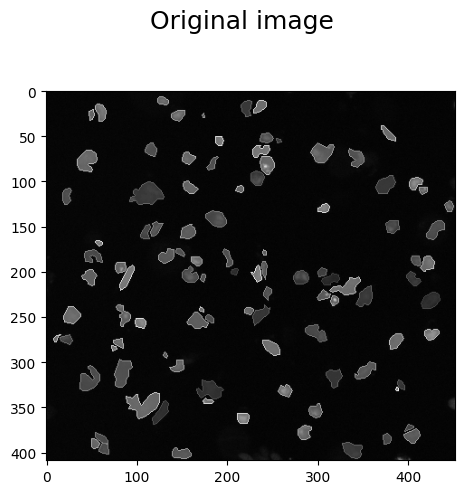

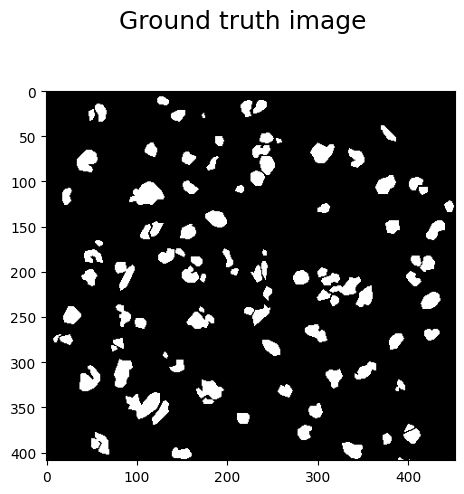

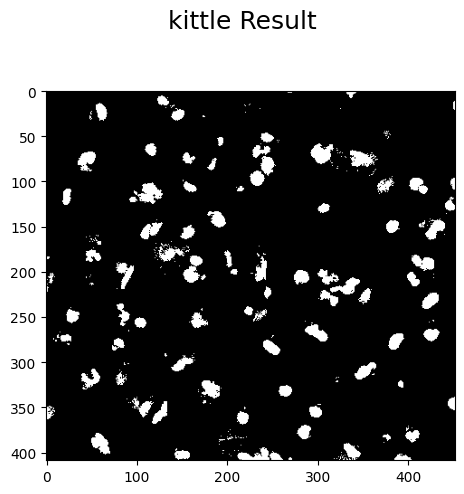

In [12]:
path_image_ground_truth = groundtruth_images_path + "D4_02_1_1_DAPI_577_overlay.png"
path_image_original = original_images_path + "D4_02_1_1_DAPI_577.png"

image_kittler = segment_image_kittler(path_image_original)
image_ground_truth = load_ground_truth_image(path_image_ground_truth)

show_image(image_ground_truth, "Ground truth image", "", vmin = 0, vmax = 1)
show_image(image_kittler, "kittle Result", "", vmin = 0, vmax = 1)


metrics = sg.write_metrics(labels=[1],
                        gdth_img=image_ground_truth,
                        pred_img=image_kittler,
                        csv_file="metrics_test.csv",
                        fully_connected=False)
print("Metrics ")
print(metrics)

# **Creación del Modelo de SAM (Tratamiento B)**

In [13]:
#Creacion de path y carga del modelo SAM
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#Checkpoint de Sam
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
#Utilizar CUDA
device = "cuda"
# Crear modelo
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
# Generar Mascara para Sam
mask_generator = SamAutomaticMaskGenerator(sam)

In [14]:
def show_anns_binary(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #ax = plt.gca()
    #ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    i = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        #i == 0 is the background

        if(i == 0):
          #put the background in 0
          color_mask = np.concatenate([np.zeros(3), [0]])
        else:
          #masks in 1
          color_mask = np.concatenate([np.ones(3), [1]])
        img[m] = color_mask
        i += 1
    #ax.imshow(img)
    img_binary = img[:, :, 0] + img[:, :, 1] + img[:, :, 2] + img[:, :, 3]
    img_binary[img_binary > 1] = 1.0
    return img_binary

def getSAM(image):
  sam_checkpoint = "sam_vit_h_4b8939.pth"
  model_type = "vit_h"

  device = "cuda"

  sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
  sam.to(device=device)

  mask_generator = SamAutomaticMaskGenerator(sam)
  masks = mask_generator.generate(image)
  #print(len(masks))
  #print(masks[0].keys())
  return masks

In [15]:
"""
Segmenta una imagen utilizando el modelo SAM
@param model, la instancia del modelo
@param points_per_side, puntos a utilizar para obtener máscaras más detalladas
@param pred_iou_thresh, umbral para filtrar las predicciones utilizando la intersección sobre unión (IoU)
@param stability_score_thresh, umbral para filtrar las predicciones por el puntaje de estabilidad
@param crop_n_layers, cantidad de capas a recortar durante la generación de máscaras. Puede ser útil para omitir las últimas capas.
@param crop_n_points_downscale_factor, reduce los puntos después del recorte. Cuanto mayor sea el valor (más rápido), menor será la precisión.
@param min_mask_region_area, área mínima para la región de la máscara. Las áreas más pequeñas se omitirán en el posprocesamiento.
"""
"""
Segment an image using the SAM model
@param model, the model instance
@param points_per_side, points to be used to get more detailed masks
@param pred_iou_thresh, threshold to filter preds using intersection over union
@param stability_score_thresh, threshold to filter preds by the stability score
@param crop_n_layers, quantity of layers to crop while mask generation. Can  be useful to skip the last layers.
@param crop_n_points_downscale_factor, reduces the points after cropping.   The faster (bigger value) the lesser accurate.
@param min_mask_region_area, min area for the mask region. Smaller ones will   be skipped on postprocessing.
"""

def segment_image_sam(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  mask_generator_2 = SamAutomaticMaskGenerator(
      model=sam,
      points_per_side=32,                #Points to segmentate
      pred_iou_thresh=0.86,
      stability_score_thresh=0.92,
      crop_n_layers=1,
      crop_n_points_downscale_factor=2,
      min_mask_region_area=100,          #Requires open-cv to run post-processing
  )
  masks2 = mask_generator_2.generate(image)
  img_sam_result = show_anns_binary(masks2)
  return img_sam_result



1it [00:00, 11.91it/s]


Metrics 
[{'label': [1], 'dice': [0.7334660065640572], 'jaccard': [0.5791127678888893], 'precision': [0.6738888576903307], 'recall': [0.8045989273893689], 'fpr': [0.042236039488442415], 'fnr': [0.19540101733453002], 'vs': [-0.17681590284951249], 'hd': [82.61961364746094], 'msd': [4.147578527104612], 'mdsd': [1.0], 'stdsd': [9.579979979433144], 'hd95': [26.003844833374004]}]


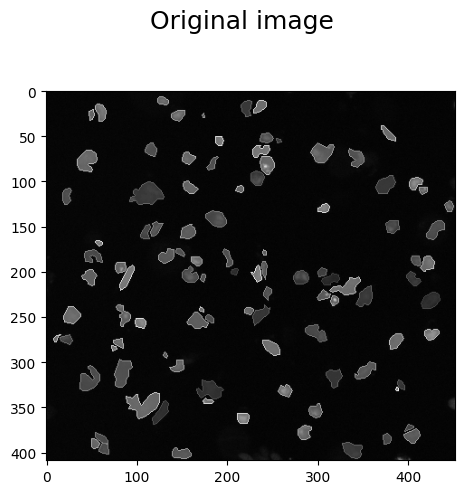

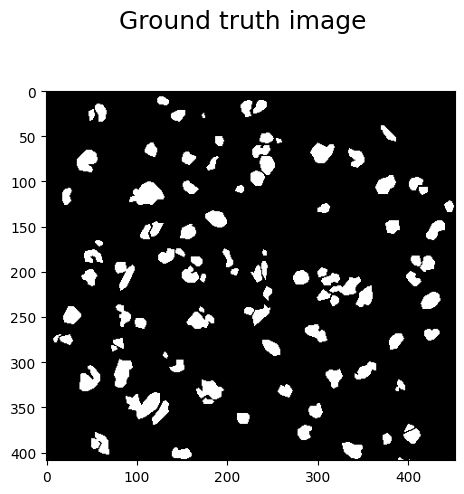

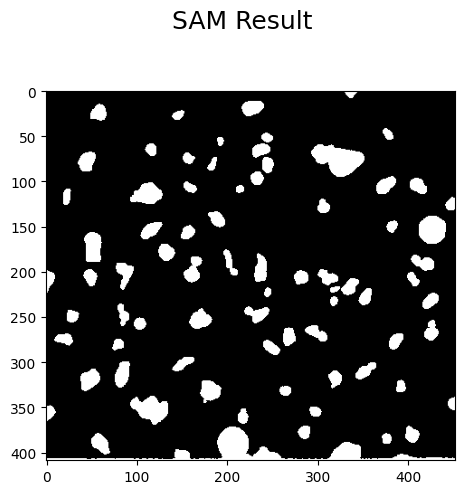

In [16]:
#Prueba de carga con el modelo SAM

#Definir path de imagen Ground Truth y original
path_image_ground_truth = groundtruth_images_path + "D4_02_1_1_DAPI_577_overlay.png"
path_image_original = original_images_path + "D4_02_1_1_DAPI_577.png"

#Procesar Imagenes a traves de las funciones SAM y Ground Truth
image_sam = segment_image_sam(path_image_original)
image_ground_truth = load_ground_truth_image(path_image_ground_truth)

#Mostrar Imagen resultante
show_image(image_ground_truth, "Ground truth image", "", vmin = 0, vmax = 1)
show_image(image_sam, "SAM Result", "", vmin = 0, vmax = 1)

#Verificar dice score entre las imagenes
metrics = sg.write_metrics(labels=[1],
                        gdth_img=image_ground_truth,
                        pred_img=image_sam,
                        csv_file="metrics_test.csv",
                        fully_connected=False)
print("Metrics ")
print(metrics)

In [17]:
print(image_sam.shape)
print(image_ground_truth.shape)

(409, 452)
(409, 452)


# **Resolución del Caso**

## **(10 puntos) Implemente en pytorch la métrica de Dice usando las operaciones básicas de pytorch. Puede comparar lo obtenido con el uso de la biblioteca seg-metrics https://pypi.org/project/seg-metrics/.**

In [18]:
#Define Function
def dice_calc (pred,ground):
  intersection = torch.sum(pred*ground) #Intersection between matrixes
  pred_sum = torch.sum(pred) #Get Predictive Matrix Value
  ground_sum = torch.sum(ground) #Get Ground Matrix Value
  equation = (2*intersection)/(pred_sum+ground_sum) #Apply Dice equation
  dice = torch.mean(equation)
  return dice


### **Prueba Unitaria 1. Se calcula el dice con la función creada y se compara con la librería seg-metrics para la imagen D4_02_1_1_DAPI_001.png**

1it [00:00, 20.38it/s]


Metrics 
[{'label': [1], 'dice': [0.7809753693349124], 'jaccard': [0.640655938927846], 'precision': [0.8488982364161879], 'recall': [0.7231165972349034], 'fpr': [0.008628999159443132], 'fnr': [0.27688331666953797], 'vs': [0.16002603561299922], 'hd': [49.497474670410156], 'msd': [3.848656550065083], 'mdsd': [1.0], 'stdsd': [8.24973736017696], 'hd95': [24.43354873657225]}]


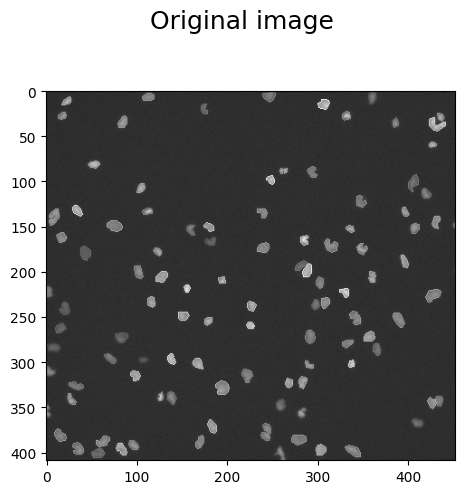

In [19]:
path_image_ground_truth = groundtruth_images_path + "D4_02_1_1_DAPI_001_overlay.png"
path_image_original = original_images_path + "D4_02_1_1_DAPI_001.png"

s1_image_sam = segment_image_sam(path_image_original)
s1_image_ground_truth = load_ground_truth_image(path_image_ground_truth)

metrics = sg.write_metrics(labels=[1],
                        gdth_img=s1_image_ground_truth,
                        pred_img=s1_image_sam,
                        csv_file="metrics_test.csv",
                        fully_connected=False)
print("Metrics ")
print(metrics)

In [20]:
t1_image_sam = torch.tensor(s1_image_sam)
t1_image_ground_truth = torch.tensor(s1_image_ground_truth)
result1 = dice_calc(t1_image_sam ,t1_image_ground_truth)
print(result1)

tensor(0.7810, dtype=torch.float64)


### **Prueba Unitaria 2. Se calcula el dice con la función creada y se compara con la librería seg-metrics para la imagen D4_02_1_1_DAPI_145.png**

1it [00:00, 12.66it/s]


Metrics 
[{'label': [1], 'dice': [0.8448480281087362], 'jaccard': [0.7313739219312546], 'precision': [0.8670808438669076], 'recall': [0.8237268041824766], 'fpr': [0.013020025222450144], 'fnr': [0.17627313794715638], 'vs': [0.05128205128205128], 'hd': [58.41232681274414], 'msd': [1.8176845660315242], 'mdsd': [1.0], 'stdsd': [5.181389371367892], 'hd95': [9.05538558959961]}]


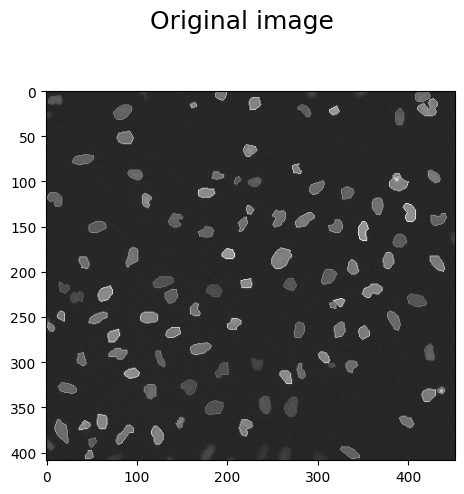

In [21]:
path_image_ground_truth = groundtruth_images_path + "D4_02_1_1_DAPI_145_overlay.png"
path_image_original = original_images_path + "D4_02_1_1_DAPI_145.png"

s2_image_sam = segment_image_sam(path_image_original)
s2_image_ground_truth = load_ground_truth_image(path_image_ground_truth)

metrics = sg.write_metrics(labels=[1],
                        gdth_img=s2_image_ground_truth,
                        pred_img=s2_image_sam,
                        csv_file="metrics_test.csv",
                        fully_connected=False)
print("Metrics ")
print(metrics)

In [22]:
t2_image_sam = torch.tensor(s2_image_sam)
t2_image_ground_truth = torch.tensor(s2_image_ground_truth)
result2 = dice_calc(t2_image_sam ,t2_image_ground_truth)
print(result2)

tensor(0.8448, dtype=torch.float64)


## **(20 puntos) Implemente 30 particiones diferentes de los datos de validación, donde cada muestra sea de 5 imágenes, con reemplazo. Asegúrese que las particiones sean la misma utilizada para probar ambos tratamientos.**

Para la resolución de esta pregunta en estudio, se debe separar en dos secciones. La primera, es generar un batch con todas las imagenes dentro de cada path, tando de imágenes originales como de Ground Truth, esto con el fin de simplificar reducción de procesamiento computacional a la hora de aplicar el tratamiento a cada muestra.
La segunda parte es la creación de la función que realizará la participación.

## **Seccion 1. Crear una función de batch para cada tratamiento.**


In [23]:
def create_batch(path,treatment):
  file_names = [file for file in os.listdir(path )]
  file_names.sort()
  batch_size = len(file_names)
  #batch = torch.zeros(batch_size,409,452)
  batch = torch.tensor([])
  for i,filename in enumerate(file_names):
    print(filename)
    path_image_original = path+str(filename)
    imagen=torch.tensor(treatment(path_image_original))
    batch = torch.cat((batch, imagen.unsqueeze(0)), dim=0)
  return batch


### **Cargar las imagenes y aplicar el tratamiento Sam**

In [24]:
  treatment = segment_image_sam
  path=original_images_path
  images_Sam = create_batch(path,treatment)
  images_Sam.shape

C4_02_1_1_DAPI_001.png
C4_02_1_1_DAPI_145.png
C4_02_1_1_DAPI_200.png
C4_02_1_1_DAPI_255.png
C4_02_1_1_DAPI_289.png
C4_02_1_1_DAPI_433.png
C4_02_1_1_DAPI_577.png
D4_02_1_1_DAPI_001.png
D4_02_1_1_DAPI_145.png
D4_02_1_1_DAPI_289.png
D4_02_1_1_DAPI_433.png
D4_02_1_1_DAPI_577.png


torch.Size([12, 409, 452])

### **Cargar las imagenes y aplicar el tratamiento Kittler**

In [25]:
treatment = segment_image_kittler
path=original_images_path
images_kittler = create_batch(path,treatment)
images_kittler.shape

C4_02_1_1_DAPI_001.png
C4_02_1_1_DAPI_145.png
C4_02_1_1_DAPI_200.png
C4_02_1_1_DAPI_255.png
C4_02_1_1_DAPI_289.png
C4_02_1_1_DAPI_433.png
C4_02_1_1_DAPI_577.png
D4_02_1_1_DAPI_001.png
D4_02_1_1_DAPI_145.png
D4_02_1_1_DAPI_289.png
D4_02_1_1_DAPI_433.png
D4_02_1_1_DAPI_577.png


torch.Size([12, 409, 452])

### **Cargar las imagenes ground**

C4_02_1_1_DAPI_001_overlay.png
C4_02_1_1_DAPI_145_overlay.png
C4_02_1_1_DAPI_200_overlay.png
C4_02_1_1_DAPI_255_overlay.png
C4_02_1_1_DAPI_289_overlay.png
C4_02_1_1_DAPI_433_overlay.png
C4_02_1_1_DAPI_577_overlay.png
D4_02_1_1_DAPI_001_overlay.png
D4_02_1_1_DAPI_145_overlay.png
D4_02_1_1_DAPI_289_overlay.png
D4_02_1_1_DAPI_433_overlay.png
D4_02_1_1_DAPI_577_overlay.png


torch.Size([12, 409, 452])

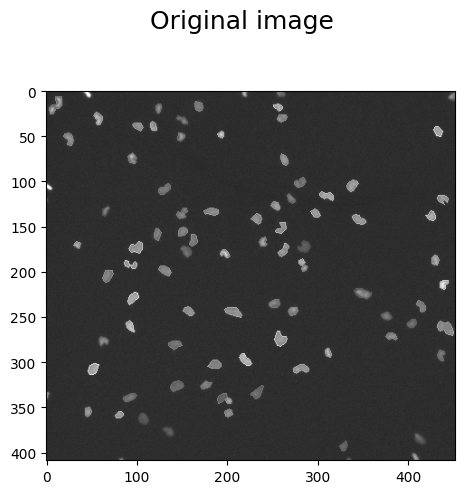

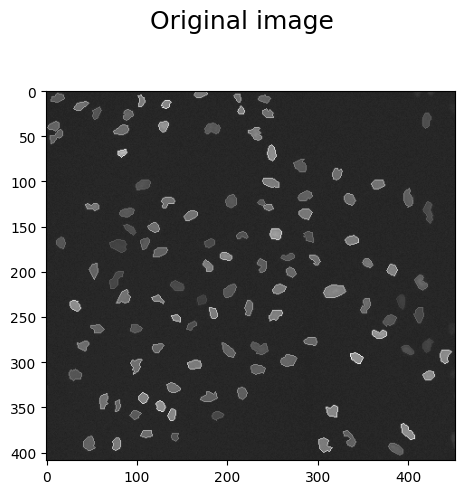

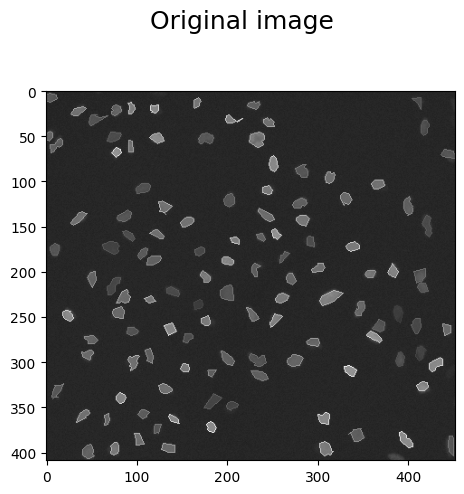

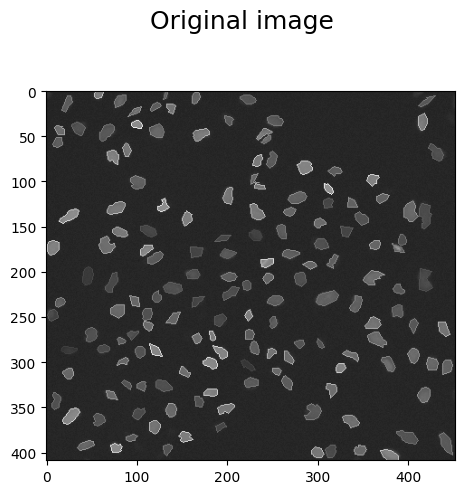

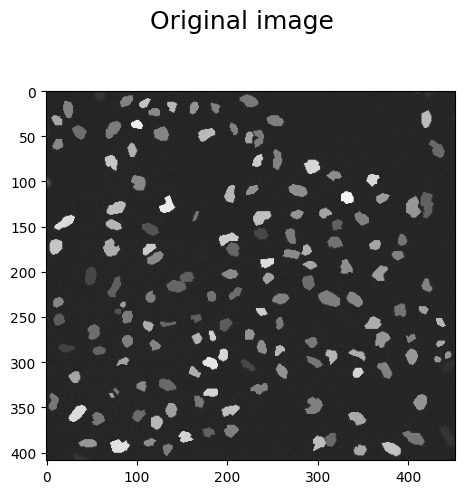

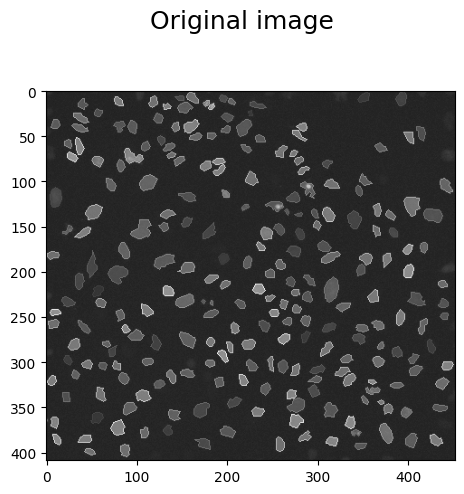

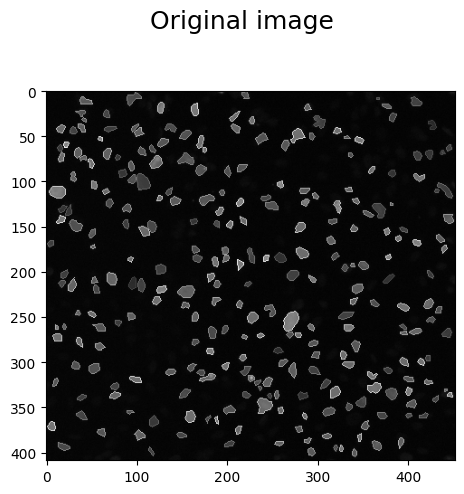

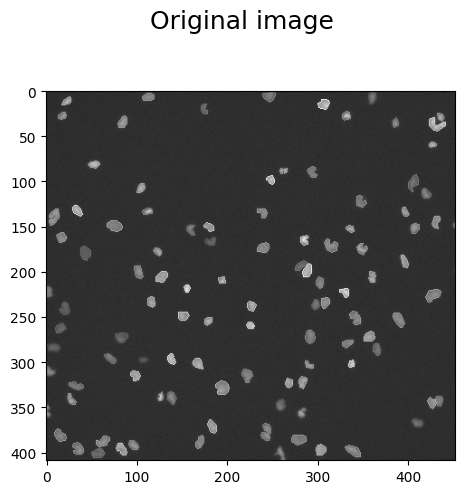

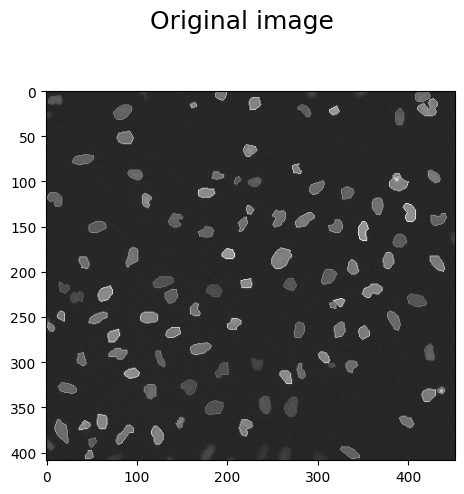

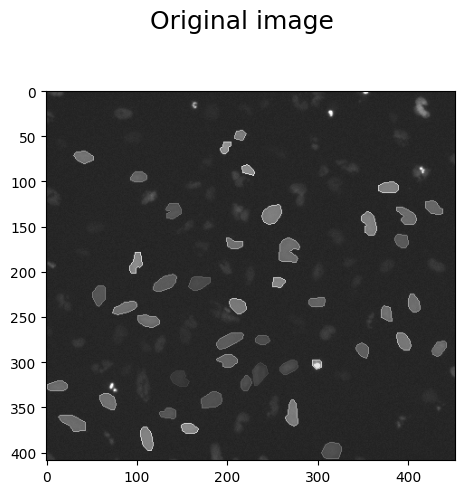

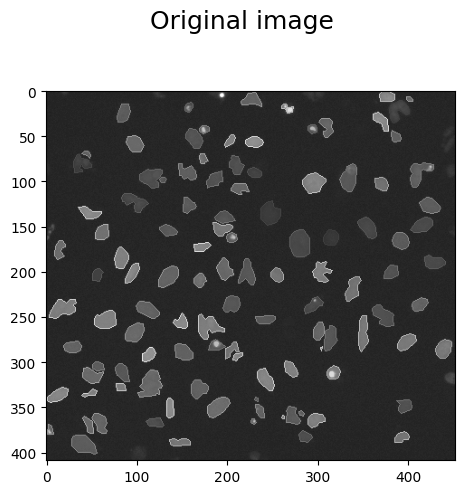

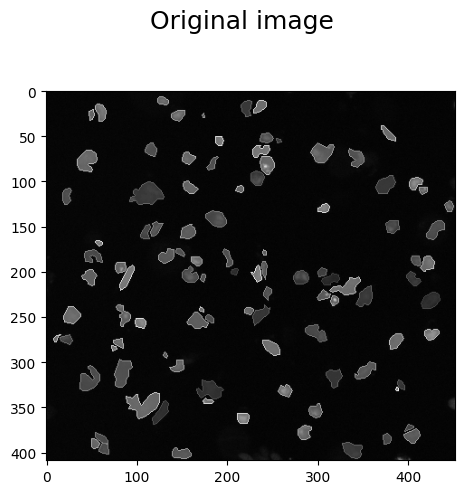

In [26]:
treatment = load_ground_truth_image
path=groundtruth_images_path
images_ground = create_batch(path,treatment)
images_ground.shape

## **Sección 2. Crear función para obtener una muestra de 30 réplicas, con 5 imágenes de cada muestra.**

In [ ]:
# Seleccionar aleatoriamente N elementos para crear las muestras, se selecionan las mismas imagens para los 3  grupos kittler, Sam y los ground
# Number seria el numero de imágenes por cada muestra
def samples(images_ground,images_Sam,images_kittler,number=5,sample=30):

  rows= images_ground[0].size(0)
  cols = images_ground[0].size(1)
  samples_images_ground = torch.zeros(sample,number,rows,cols)
  samples_images_Sam = torch.zeros(sample,number,rows,cols)
  samples_images_kittler = torch.zeros(sample,number,rows,cols)
  indices = np.arange(len(images_ground))
  for i in range(0,sample):

    np.random.seed(i)
    selected_indices = np.random.choice(indices, size=number, replace=True) #Con reemplazo

  # Convertir los arrays de NumPy a tensores de PyTorch
    selected_indices = torch.tensor(selected_indices)

  # Crear los grupos de imágenes espejo para images_ground e images_Sam
    group_images_ground = torch.index_select(images_ground, 0, selected_indices)
    group_images_Sam = torch.index_select(images_Sam, 0, selected_indices)
    group_images_kittler= torch.index_select(images_kittler, 0, selected_indices)

    samples_images_ground[i]=group_images_ground
    samples_images_Sam[i]=group_images_Sam
    samples_images_kittler[i]=group_images_kittler


  return samples_images_ground,samples_images_Sam,samples_images_kittler

In [ ]:
## Crear la Matriz con el conjunto de muestras
samples_images_ground,samples_images_Sam,samples_images_kittler= samples(images_ground,images_Sam,images_kittler)
print("Grupo de imágenes espejo de images_ground:")
print(samples_images_ground.unique())

print("Grupo de imágenes espejo de images_Sam:")
print(samples_images_Sam.unique())

print("Grupo de imágenes espejo de images_kittler:")
print(samples_images_kittler.unique())

### **a) Documente como se utiliza la herramienta seleccionada para realizar las particiones.**

Para crear las particiones de datos se decide hacerlo con las imgenes despues de ser procesadas por el tratamiendo seleccionado, es decir primero se
generan las imagen umbralizadas por medio de «SAM» y «Kittler» de todas
las muestras disponibles, para luego efectuar las 30 particiones.
Esta seria la secucuencia utilizada; esto permite que los tratamientos solo
se corran la cantidad de imagenes unicas que hay, que este caso son 12 y no 30
corridas por 5 muestras, que serian 150 veces lo cual evidentemente tardaria
mas tiempo en ejecutarse.
1. Se crean las imagenes umbralizadas con para cada algoritmo utilizando
el codigo mostrado en la figura 4; basicamente busca los archivos de un «path»
que recibe de entrada, luego les aplica el tratamiento que tambien recibe como
entrada y finalmente tiene como salida el los tensores de las imagenes umbralizadas.
2. Se procede a correr la funcion «create_batch» para todas la imagnes del
datase gliomastoma del folder original con los diferentes tratamientos
3. Se crea la funcion que genera las N corridas con X imagenes por corrida;
esta funcion recibe 3 tensores de igual tamano con las imagenes ya procesadas
y el «ground truth», ademas el numero de muestras y el numero de corridas.
4. Para seleccionar los samples de cada corrida el codigo toma 5 indices con
reemplazo para cada corrida y utiliza esos indices para seleccionar las imagenes correspondientes en los tensores de entradas
5. Despues uno en un tensor las muestras de cada corrida
6. La funcion tiene por salida los 3 tensores de imágenes de 150 imagnes,
de 30 corridas con 5 imagenes cada uno

### **b) Pruebe ambos tratamientos en las particiones definidas. Para el modelo SAM, utilice los siguientes parámetros:**

- points_per_side =32
- pred_iou_thresh =0 .86
- stability_score_thres = 0.92
- crop_n_layers =1
- crop_n_points_downscale_factor =2
- min_mask_region_area =100



#### **Explique qué controla cada parámetro según la documentación del modelo**

- **Points_per_side:** Este parámetro determina la cantidad de puntos utilizados
para segmentar la imagen. Cuanto mayor sea este valor, más detalladas serán
las máscaras generadas, pero también podría aumentar el tiempo de procesamiento. Puedes probar con diferentes valores para encontrar el equilibrio entre detalle y tiempo de ejecución
- **Stability_score_thresh:** Este umbral filtra las predicciones en función del puntaje de estabilidad. Un valor más alto podría resultar en máscaras más estables, pero también podría filtrar regiones relevantes. Prueba diferentes valores para encontrar un equilibrio.
- **Crop_n_layers:** la prediccion de mascara sera re ejecutada y establece el numero de capas que se ejecutaran.
- **Crop_n_points_dowscale_factor:** Estos parámetros están relacionados con el
recorte de capas y puntos durante la generación de máscaras. Ajustar estos
valores puede afectar la precisión y la velocidad. Experimenta con diferentes
combinaciones para encontrar el mejor equilibrio entre precisión y tiempo de
ejecución.
- **Min_mask_region_area:** Este parámetro establece el área mínima para las regiones de máscara. Regiones más pequeñas se omitirán en el posprocesamiento. Puedes ajustar este valor según el tamaño esperado de las regiones que
deseas detectar.
- **Pred_iou_thresh:** Este parámetro establece el área mínima para las regiones
de máscara. Regiones más pequeñas se omitirán en el posprocesamiento. Puedes ajustar este valor según el tamaño esperado de las regiones que deseas
detectar.


### **c) Valide que ambos tratamientos utilizan las mismas particiones y muestre la evidencia.**

Para validar que el codigo esta generando las muestras con las mismas imagenes para cada set de imagenes, se procede a utilizar en el codigo las imagenes de ground thruth simulando que son 3 sets diferentes de imagenes, luego
se comparan las muestras para verificar que son iguales.

In [29]:
## crear una muesta se debe repertir 30 veces
images_ground_G1,images_ground_G2,images_ground_G3= samples(images_ground,images_ground,images_ground)
print("Comparar las imagenes de la muestras 1 y 2")
print((images_ground_G1 == images_ground_G2).all())
print("Comparar las imagenes de la muestra 1 y 3")
print((images_ground_G1 == images_ground_G3).all())
print("Comparar las imagenes de la muestra 2 y 3")
print((images_ground_G2 == images_ground_G3).all())

Comparar las imagenes de la muestras 1 y 2
tensor(True)
Comparar las imagenes de la muestra 1 y 3
tensor(True)
Comparar las imagenes de la muestra 2 y 3
tensor(True)


Por ende, los resultados indican, que al simular el ground truth como tratamiento, y compararlo contra el ground truth original, efectivamente son iguales, es decir, las 3 matrices tienen el mismo conjunto de valores en cada imágen.

### **d) Defina si bajo tales condiciones, los datos están apareados o no (es un paired-test o no?).**

Para determinar si una muestra de datos es «paired-test» o no, se debe verificar la independencia de las muestras, es decir que no debe haber correlacion entre los valores obtenidos; esto es aplicable en el caso que se tengan dos
problaciones, individuos o conjunto de datos distintos y se quisieran analizar
como dependientes a pesar de tener valores estadisticos diferentes, como se
menciona en el articulo [1]. Para determinar si es «paired test» se debe evaluar si la prueba se hace sobre los mismo sujetos bajo diferentes condiciones or
diferente momento, mientras que «un-paired test» las muestras no estan directamente relacionadas.
En este caso, debido a que es el mismo conjunto de datos y la misma muestra, sólo que se están aplicando tratamientos distintos, se puede decir que los
datos están apareados, es decir, corresponde a un paired-test, esto principalmente al hecho de que lo que se quiere ev

**Referencia**

[1] Manfei Xu, Drew Fralick,Julia Zheng, Bokai Wang, Xin Tu & Changyong Feng (June 25, 2017). The Differences and Similarities Between Two-Sample T-Test and Paired T-Test. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5579465/#:~:text=3.3%20Differences%20between%20the%20two,the%20form%20of%20matched%20pairs.

## **2.(10 puntos) Ejecute las N = 30 replicas para los K = 2 tratamientos y mida el puntaje de Dice.**

In [30]:
def calculate_samples_dice(samples_images_ground,samples_images_sam,samples_images_kittler):

  N = samples_images_ground.size(0) #Numero de muestras
  image_batch = len(samples_images_ground[0]) #Numero de imagenes por muestra
  dice_batch_sam = np.zeros(image_batch)
  dice_batch_kittler = np.zeros(image_batch)
  dice_sam_result = np.zeros(N)
  dice_kittler_result = np.zeros(N)
  for i in range(0,N):
    #Separar el total de muestras en batches
    batch_ground = samples_images_ground[i]
    batch_sam = samples_images_sam[i]
    batch_kittler = samples_images_kittler[i]
    for j in range(0,image_batch):
      #Obtener imagen por cada valor
      image_ground = batch_ground[j]
      image_sam = batch_sam[j]
      image_kittler = batch_kittler[j]
      #Obtener coeficiente de Dice para SAM
      sam_result = dice_calc(image_sam,image_ground)
      dice_batch_sam[j] = sam_result.item()
      #Obtener coeficiente de Dice para Kittler
      kittler_result = dice_calc(image_kittler,image_ground)
      dice_batch_kittler[j] = kittler_result.item()

    #Agregar el promedio por batch por cada muestra
    dice_sam_result[i] = np.mean(dice_batch_sam)
    dice_kittler_result[i] = np.mean(dice_batch_kittler)

  #Generar una matriz con muestras
  sample_numbers = np.array(range(1,31))

  #Crear tabla con los resultados
  results_table = pd.DataFrame(
      {
          "Sample":sample_numbers,
          "Dice for Sam":dice_sam_result,
          "Dice for Kittler": dice_kittler_result
      }
  )
  results_table = results_table.reset_index(drop=True)
  descriptive_statistics = pd.DataFrame(
      {
          "Treatment":['Sam','Kittler'],
          "Mean":[np.mean(dice_sam_result),np.mean(dice_kittler_result)],
          "Median":[statistics.median(dice_sam_result),statistics.median(dice_kittler_result)],
          "Standard Deviation":[np.std(dice_sam_result),np.std(dice_kittler_result)],
          "Skewness":[skew(dice_sam_result),skew(dice_kittler_result)],
          "Kurtosis": [kurtosis(dice_sam_result),kurtosis(dice_kittler_result)]
      }
  )

  return results_table,descriptive_statistics

### **a) Reporte una tabla con los resultados y las siguientes estadísticas descriptivas: media, mediana, desviación estándar e inclinación.**

In [31]:
#Crear tabla con valores de cada muestra
results_table,descriptive_statistics=calculate_samples_dice(samples_images_ground,samples_images_Sam,samples_images_kittler)
print(results_table)
print(descriptive_statistics)

    Sample  Dice for Sam  Dice for Kittler
0        1      0.759149          0.731997
1        2      0.744022          0.730245
2        3      0.771739          0.789167
3        4      0.759673          0.729191
4        5      0.818693          0.791784
5        6      0.697521          0.765523
6        7      0.750288          0.683261
7        8      0.701241          0.692159
8        9      0.757655          0.703020
9       10      0.747220          0.767476
10      11      0.770083          0.779820
11      12      0.759777          0.822729
12      13      0.749431          0.775981
13      14      0.786801          0.824602
14      15      0.725499          0.792282
15      16      0.819056          0.807819
16      17      0.716427          0.709571
17      18      0.725910          0.802021
18      19      0.803048          0.733804
19      20      0.791152          0.721387
20      21      0.750288          0.683261
21      22      0.792241          0.816381
22      23 

In [32]:
#Grabar valores de tabla en un array individual
results_table = pd.DataFrame(
    {
        "Sample":range(1,31),
    'Dice for Sam': [
        0.759149, 0.744022, 0.771739, 0.759673, 0.818693,
        0.697521, 0.750288, 0.701241, 0.757655, 0.747220,
        0.770083, 0.759777, 0.749431, 0.786801, 0.725499,
        0.819056, 0.716427, 0.725910, 0.803048, 0.791152,
        0.750288, 0.792241, 0.798869, 0.697671, 0.787099,
        0.771856, 0.769316, 0.816279, 0.751616, 0.793471
    ],
    'Dice for Kittler': [
        0.731997, 0.730245, 0.789167, 0.729191, 0.791784,
        0.765523, 0.683261, 0.692159, 0.703020, 0.767476,
        0.779820, 0.822729, 0.775981, 0.824602, 0.792282,
        0.807819, 0.709571, 0.802021, 0.733804, 0.721387,
        0.683261, 0.816381, 0.769986, 0.742147, 0.820381,
        0.779637, 0.805769, 0.813526, 0.732447, 0.765324
    ]
})


print(results_table)

    Sample  Dice for Sam  Dice for Kittler
0        1      0.759149          0.731997
1        2      0.744022          0.730245
2        3      0.771739          0.789167
3        4      0.759673          0.729191
4        5      0.818693          0.791784
5        6      0.697521          0.765523
6        7      0.750288          0.683261
7        8      0.701241          0.692159
8        9      0.757655          0.703020
9       10      0.747220          0.767476
10      11      0.770083          0.779820
11      12      0.759777          0.822729
12      13      0.749431          0.775981
13      14      0.786801          0.824602
14      15      0.725499          0.792282
15      16      0.819056          0.807819
16      17      0.716427          0.709571
17      18      0.725910          0.802021
18      19      0.803048          0.733804
19      20      0.791152          0.721387
20      21      0.750288          0.683261
21      22      0.792241          0.816381
22      23 

### **b) Comente los resultados y responda las siguientes dos preguntas: Según los estadísticos descriptivos calculados, cree usted que exista un tratamiento con mejora significativa?**

De acuerdo con los resultados obtenidos, se observa que el valor de Dice de
ambos tratamientos ronda es aproximadamente 0.76, lo que indica que la similitud
entre las imágenes originales, al compararlas contra las imágenes tratadas
es de un 76 %.

Adicional a esto, al comparar los resultados entre ambos tratamientos, se
observa que Kittler y SAM tiene resultados muy similares, y esto se demustra
al observar que la media de Dice-Score obtenido es de 0.76, de igual manera,
la mediana es ligeramente inferior a la media para SAM casos y practicamente
igual Kittler, y con desviaciones estándar de 0.0339 y 0.0.0431, se procede a calcular
el coeficiente de variacion, para entender la volatilidad de los resultados:

$$ Error Sam = {{0.033947}\
\over {0.762770}}=0.044504$$

$$ Error Kittler = {{0.043171}\
\over {0.762757}}=0.056598$$

Por lo tanto, se observa que la dispersión obtenida en cada trantamiento, es
de 5% aproximadamente, donde Kittler es el tratamiento con mayor coeficiente
de variación, es decir, con mayor variabilidad en los resultados.

Lo anterior indica que no hay diferencia significativa entre los
resultados de ambos tratamientos, no obstante se debe resaltar el hecho de que
el modelo Sam eventualmente podría tener una mejora significativa, es decir,
puede que los parámetros usados para este tratamiento no sean los óptimos,
mientras que el algoritmo de Kittler, ya logra su función esperada con la segmentación
de las imágenes.

### **c) Además, según tales estadísticos, usted valora posible que las tasas de aciertos de ambos tratamientos sigan una distribución normal?**

Con base en las estadísticas descriptivas, se puede observar que hay algunas
características que indican que los datos obtenidos siguen una distribución
normal, por ejemplo, se dice que una distribución normal posee una media,
mediana y moda de igual valor, es decir, estos 3 indicadores son iguales, y de
acuerdo con los valores obtenidos en ambos tratamientos, se muestra que la media y la mediana están muy cercanas entre sí, por lo que podría ajustarse
una normalidad.

Otra característica importante es que el skewness pese a ser negativo, es un
valor relativamente bajo y cercvano a 0, por lo que se dice que su inclinación
no es a un solo lado en particular, sino que siguen una centricidad.

Por otro lado, el valor de Kurtosis obtenido es negativo en ambos tratamientos,
es decir, hay inexistencia o pocos valores extremos en el conjunto de
resultados, sin embargo, el articulo [2] describe a este tipo de curtosis como
**platykurtic**, que segun el autor, es una característica típica de una distribución
uniforme, ya que el pico o frecuencia de los valores es inferior y más
plano, pero aun así, al estar apenas -1 valor de k, sus valores podrían ajustarse
a una distribución normal.

Finalmente, de acuerdo con la teoría del límite central, descrita por [3], indica
que las medias de las muestras de las observaciones, siguen una distribución
normal, es decir, en este caso, se tiene 5 imágenes por muestra, con 30 muestras
en total, lo que representa 150 imágenes, por ende, se podría asumir que este
proceso y resultado, seguiría una distribución normal.
Por lo tanto, a este punto, con las estadísticas descriptivas, y la teoría detrás
de los mismos conceptos, se determina que si es posible que las tasas de
aciertos de ambos tratamientos sigan una distribución normal.

**Referencias**

[2] Suvarna Gawali (July 17, 2023). Skewness and Kurtosis: Quick Guide. https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/

[3] Saúl Calderón (July 27, 2023). Probabilidades y estadística para Ciencias de
los Datos.

## **3. (20 puntos) Utilizando los resultados obtenidos en el punto anterior, realice las siguientes gráficas:**


### **a) Un histograma del puntaje de Dice por cada tratamiento**

In [33]:
#Crear funnción para histogramas
def plot_bar(bins, histogram, axis_x_label, axis_y_label, title):
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    width = np.max(bins) / bins.shape[0]
    print("Width: ", width)
    axes.bar(bins[0:].tolist(), histogram.tolist(),color='skyblue', width = width,linewidth = 0.8)
    plt.xlabel(axis_x_label)
    plt.ylabel(axis_y_label)
    plt.title(title)
    plt.show()

#### **Histograma de Dice para Sam**

Width:  0.05


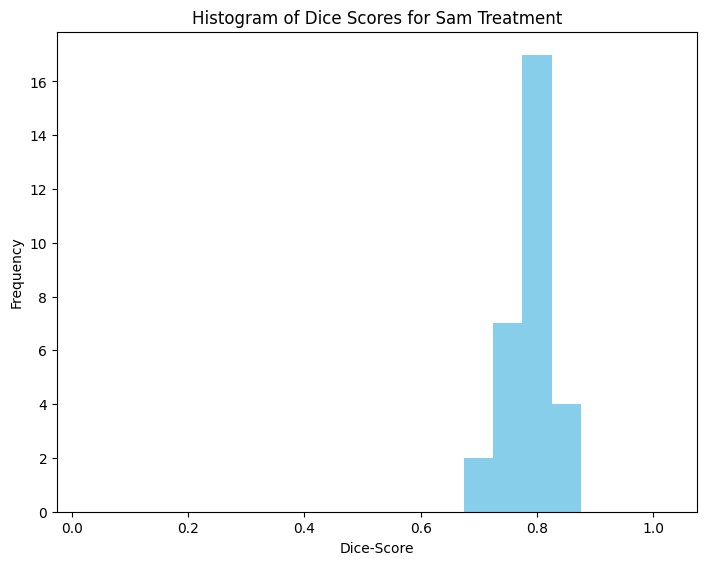

In [34]:
#Crear bines y valores con un rango de 0 a 1
histogram_sam, bins_sam= np.histogram(results_table['Dice for Sam'], bins = 20,range=(0,1))
#Graficar resultados de dice
plot_bar(bins_sam[1:], histogram_sam, "Dice-Score", "Frequency", "Histogram of Dice Scores for Sam Treatment")

#### **Histograma de Dice para KIttler**

Width:  0.05


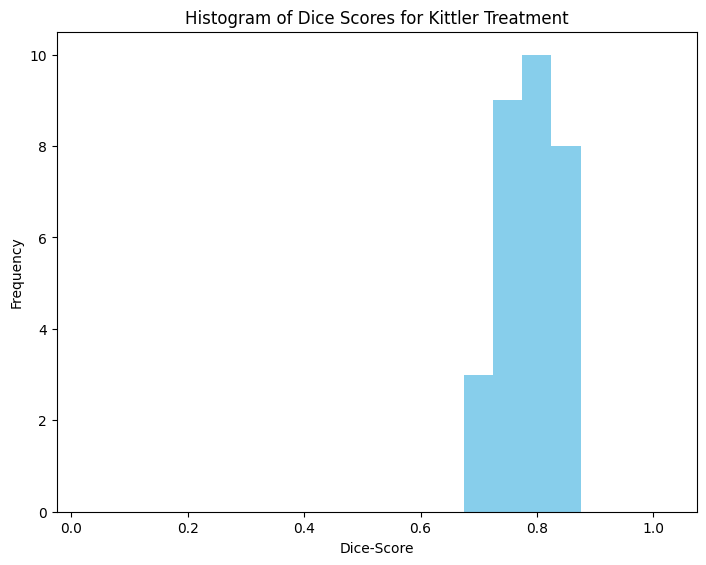

In [35]:
#Crear bines y valores con un rango de 0 a 1
histogram_kittler, bins_kittler= np.histogram(results_table['Dice for Kittler'], bins = 20,range=(0,1))
#Graficar resultados de dice
plot_bar(bins_kittler[1:], histogram_kittler, "Dice-Score", "Frequency", "Histogram of Dice Scores for Kittler Treatment")

### **b) Un diagrama de cajas, con una caja por tratamiento en un mismo gráfico.**

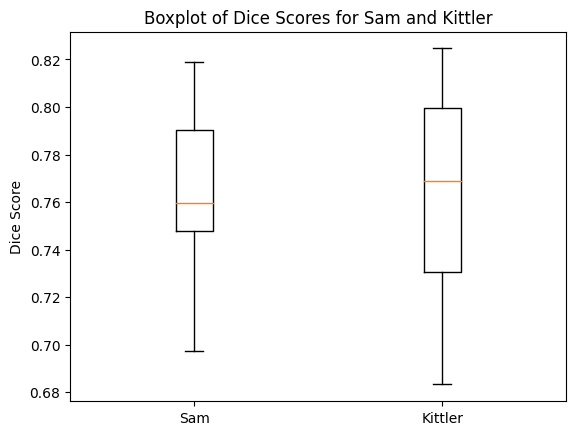

In [36]:
#Graficar boxplot
plt.boxplot([results_table['Dice for Sam'], results_table['Dice for Kittler']], labels=['Sam', 'Kittler'],showfliers=True)
plt.ylabel('Dice Score')
plt.title('Boxplot of Dice Scores for Sam and Kittler')
plt.show()

#### **c) p-p plot por cada tratamiento**

Para determinar si los datos siguen una distribución normal utilizando el
gráfico P-P (Probability-Probability Plot), se debe comparar la distribución de
los datos con la distribución teórica de una distribución normal. Si los puntos
en el gráfico P-P siguen aproximadamente una línea diagonal, eso sugiere que
los datos siguen una distribución normal. Sin embargo, si los puntos se alejan
significativamente de la línea diagonal, eso indica que los datos no siguen una
distribución normal.

Para interpretar el gráfico P-P se deben analizar los siguientes analisis:

Si los puntos están muy cerca de la línea diagonal, los datos están muy cerca
de una distribución normal. Si los puntos están por encima de la línea diagonal
en la parte izquierda del gráfico y por debajo de la línea diagonal en la parte
derecha del gráfico, los datos tienen una cola más gruesa que la distribución
normal. Si los puntos están por debajo de la línea diagonal en la parte izquierda
del gráfico y por encima de la línea diagonal en la parte derecha del gráfico, los
datos tienen una cola más delgada que la distribución normal.

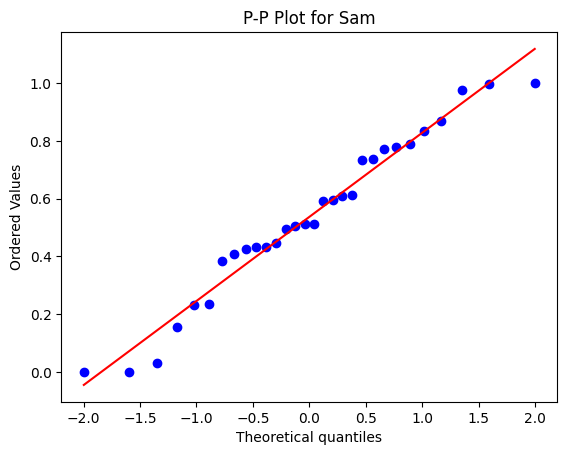

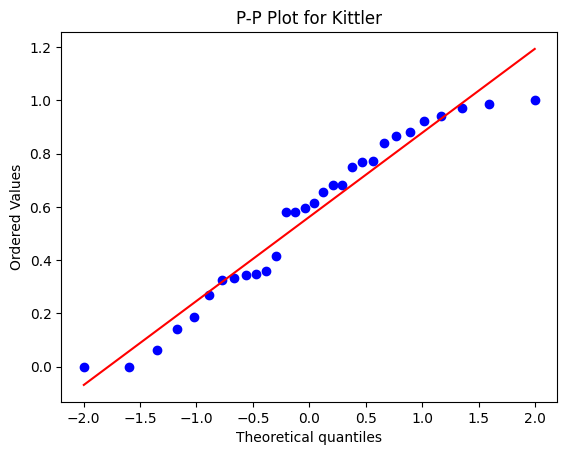

In [37]:
# Función para graficar el P-P plot
def pp_plot(data, label):
    sorted_data = sorted(data)
    norm_data = [(x - min(sorted_data)) / (max(sorted_data) - min(sorted_data)) for x in sorted_data]
    _, ax = probplot(norm_data, dist='norm', plot=plt)  # Usamos 'norm' para indicar la distribución normal
    plt.title(f'P-P Plot for {label}')





# Crear P-P plot para Sam
pp_plot(results_table['Dice for Sam'], 'Sam')
plt.show()

# Crear P-P plot para Kittler
pp_plot(results_table['Dice for Kittler'], 'Kittler')
plt.show()

#### **1) Existe algún valor extremo usando como insumo las visualizaciones anteriores? Explore los datos y defina si hay imágenes que generen un comportamiento atípico. De existir, remueva tal o tales imágenes de la muestra de prueba.**

#### **2) Cree usted que exista un tratamiento con mejora significativa?**


#### **3) Además, según tales gráficos, usted valora posible que los puntajes de Dice de ambos tratamientos sigan una distribución normal?**

Basados en los boxplot mostrados en la figura 9 no hay valores extremos o
«outliers». Ademas basados en los graficos mostrados ambos tratamientos tiene
una media practicamente igual. Basados en el analisis de P-Plot se podria
confirmar que ambas distribuciones de datos podrian considerarse normales,
ya que los datos se ubican sobre la linea como se menciono anteriormente.

## **(10 puntos) Realice una prueba de Kolmogorov-Smirnov y Jarque-Bera por cada tratamiento para verificar si los resultados de cada tratamiento siguen una distribución Gaussiana.**

### **Prueba Koglomorov Smirnov**

In [38]:
#Koglomorov-Smirnov para Sam

kstest(results_table['Dice for Sam'],cdf='norm')

KstestResult(statistic=0.7572615990529795, pvalue=2.1226088908211157e-18, statistic_location=0.697521, statistic_sign=-1)

In [39]:
#Koglomorov-Smirnov para Kittler

kstest(results_table['Dice for Kittler'],cdf='norm')

KstestResult(statistic=0.7527790333636737, pvalue=3.922183647418762e-18, statistic_location=0.683261, statistic_sign=-1)

Segun el «p-value» obtenido las dsitribuciones de ambos tratamientos no
son normales; por que se rechaza la hipotesis nula que establece que la distribucion
de los datos de prueba es normal; basados en el calculo de la prueba
KS, esta lo que hace es comparar la distribucion empirica de los datos a probar
con de la districubucion normal,

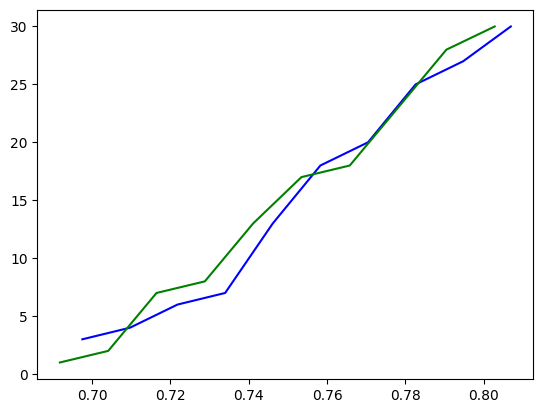

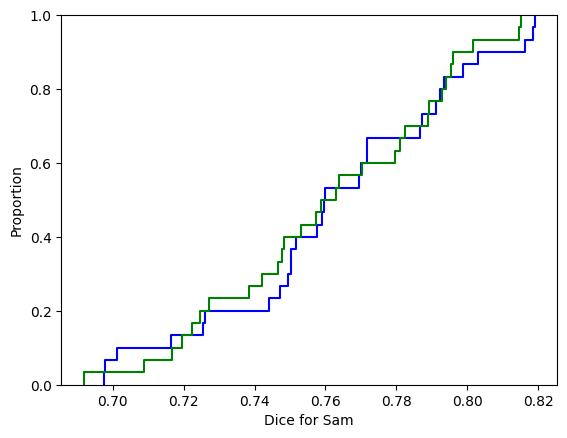

In [41]:
#Definir distribucion normal que se adapte a los momentos estadisticos del tratamiento SAM
df=results_table['Dice for Sam']
data_norm = np.random.normal(np.mean(df), np.std(df), len(df))
values, base = np.histogram(df)
values_norm, base_norm = np.histogram(data_norm)
cumulative = np.cumsum(values)
cumulative_norm = np.cumsum(values_norm)

#Mostrar frecuencia acumulada normal
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base_norm[:-1], cumulative_norm, c='green')
plt.show()

#Mostrar variaciones y cambios entre SAM y una distribucion Normal con base en KS
sns.ecdfplot(df, c='blue')
sns.ecdfplot(data_norm, c='green')
plt.show()

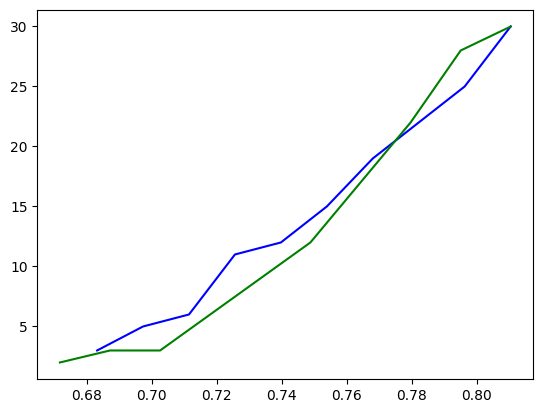

<Axes: xlabel='Dice for Kittler', ylabel='Proportion'>

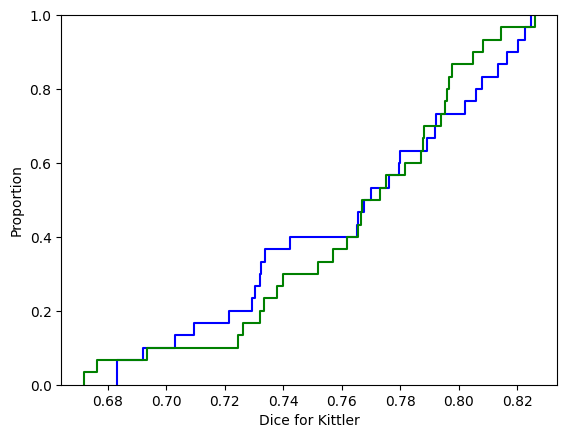

In [42]:
#Definir distribucion normal que se adapte a los momentos estadisticos del tratamiento Kittler
df1=results_table['Dice for Kittler']
data_norm1 = np.random.normal(np.mean(df1), np.std(df1), len(df1))
values1, base1= np.histogram(df1)
values_norm1, base_norm1 = np.histogram(data_norm1)
cumulative1 = np.cumsum(values1)
cumulative_norm1 = np.cumsum(values_norm1)

#Mostrar frecuencia acumulada normal
plt.plot(base1[:-1], cumulative1, c='blue')
plt.plot(base_norm1[:-1], cumulative_norm1, c='green')
plt.show()

#Mostrar variaciones y cambios entre SAM y una distribucion Normal con base en KS
sns.ecdfplot(df1, c='blue')
sns.ecdfplot(data_norm1, c='green')

Se muestra los graficos comparativos para ambos tratamientos; se puede concluir que SAM tiene un comportamiento menos «normal» comparado con Kittler, sin embargo ambos tratamientos no pasaron la prueba.

### **Prueba Jarque-Bera**

In [43]:
#Aplicar Jarque-Bera para SAM
stats.jarque_bera(results_table['Dice for Sam'])

SignificanceResult(statistic=0.7796813918067491, pvalue=0.6771647410234825)

In [44]:
#Aplicar Jarque-Bera para Kittler
stats.jarque_bera(results_table['Dice for Kittler'])

SignificanceResult(statistic=1.9214376551504082, pvalue=0.38261775090950684)

Los resultados obtenidos por la prueba Jarque Bera indican que se acepta la
hipotesis nula, ambas distribuciones son normales.Jarque-Bera test esta basado
en que tan cerca son los valores de «skewness» y «kurtosis» a los de una distribucion normal.

In [45]:
# Calculate kurtosis
SAM_kurtosis = kurtosis(results_table['Dice for Sam'])
# Calculate skewness
SAM_skewness = skew(results_table['Dice for Sam'])

print(SAM_kurtosis,SAM_skewness)

# Calculate kurtosis
Kittler_kurtosis = kurtosis(results_table['Dice for Kittler'])
# Calculate skewness
Kittler_skewness = skew(results_table['Dice for Kittler'])

print(Kittler_kurtosis,Kittler_skewness)

-0.6298675075879858 -0.23822890060313484
-1.0906120147088727 -0.2948370556311489


Con base en los resultados mostrados en la tabla 6 se puede concluir que
los datos tienen valores relativamente cercanos a los valores ideales de «0» para «skewness» and «3» para «kurtosis»; por lo que el metodo «Jarque-Bera» considera que los resultados para cada tratamiento tienen una distrucion normal.

### **a) Verifique además si hay homocedasticidad usando la función respectiva de scipy o alguna librería similar.**

Para la prueba de homocedasticidad (homogeneidad de la varianza) la libreria
«Scipy» cuenta con 3 tipos de prueba, «levene», Barlett y «Fligner-Kileen»;
estos concidearn como hipotesis nula que los datos proceden de distribuciones
con la misma varianza. El test de «Barlett» se recomienda cuando hay normalidad,
ademas «Levene» y «Barlett» permiten elegir el estadistico de centralidad
(mediana, media o media truncada)

In [46]:
#Levene test
# ==============================================================================
scipy.stats.levene(results_table['Dice for Sam'],results_table['Dice for Kittler'])

LeveneResult(statistic=2.68979795860958, pvalue=0.10640570072904293)

In [47]:
# Bartlett test
# ==============================================================================
bartlett_test = stats.bartlett(results_table['Dice for Sam'],results_table['Dice for Kittler'])
bartlett_test

BartlettResult(statistic=1.6317173462499839, pvalue=0.20146567990677344)

In [48]:
#Flinger test
# ==============================================================================
fligner_test = stats.fligner(results_table['Dice for Sam'],results_table['Dice for Kittler'], center='median')
fligner_test

FlignerResult(statistic=2.3865779049793128, pvalue=0.12238126710343376)

Basados en los resultados obtenidos se puede asumir que la varianza es
equivalente para ambos tratamientos.

## **(30 puntos) De acuerdo a las valoraciones de los 3 puntos anteriores, defina si la distribución de los puntajes de Dice son normales o no.**

Basados en los resultados anteriores, los datos siguen una distribución normal
y las varianzas son equivalentes, y adicionalmente, al tratarse un experimento
con un muestras pareadas o «paired-test» se utilizará la prueba «ttest_
rel» de la librería de SciPy; esta función recibe como entradas los set de
datos de los tratamientos que queremos comparar y tiene como salidas el estadistico y el «p-value»

In [49]:
stats.ttest_rel(results_table['Dice for Sam'],results_table['Dice for Kittler'])

TtestResult(statistic=0.001673498419542176, pvalue=0.9986762012054602, df=29)

Con base en el «p-value» obtenido de la prueba, se observa que es mayor
que 0.05, por lo que se acepta la hipotesis nula de que ambos tratamientos para
las muestras utilizadas son estadisticamente equivalentes.

### **2.6.2. Concluya entonces si la modificación propuesta por Johana es una mejora en términos del coeficiente de Dice. Analice además que otras variables sería importante tomar en cuenta para tomar una decisión final en si utilizar o no la modificación propuesta por Johana.**

Basado en los analisis efectuado, se puede concluir que la propuesta planteada
por Johana no representa una mejora significativa en la clasificación y
procesamiento de las imágenes, ya que al realizar la prueba de hipótesis, se
confirma que ambos tratamientos son equivalentes, o en este caso, que ambos
tratamientos logran los mismos resultados de clasificación basados en el «Dice
Score».

No obstante, para realmente tomar una decisión de si utilizar la propuesta de
Johana o la de Juan, se requiere realizar un estudio más profundo, con una mayor
cantidad de imágenes o muestras que se asemejen más a una población, lo
anterior debido a que se trata de un estudio enfocado en ciencias de la salud,
donde la precisión del modelo y los resultados deben poseer un alto nivel de confianza para determinar el crecimiento del tumor, y es que como se determinó
previamente, existe un error y variabilidad en los resultados de ambos
tratamientos que no se puede obviar, tal es el caso del coeficiente de variación,
donde se determinó un valor de 5% con respecto a sus respectivas medias, y pese
a que los datos siguen una distribución normal, se observa en gráficos como el
histograma, cierta dispersión de los valores, que no siguen estrictamente el supuesto
de N(μ = 0|σ = 1), por lo tanto, se sugiere recopilar mayor información
y mayores muestras individuales, obtener el mínimo márgen de error posible,
y volver a realizar el experimento, para obtener una mayor confiabilidad del
modelo a seleccionar, considerando también la posibilidad de modificar los
híperparametros utilizados en el experimento para «SAM» para optimizar el
modelo y obtener un mejor resultados.


# **(20 puntos extra) Jose, otro colega de su equipo, sugiere que se calibren los parámetros del modelo SAM para obtener mejores resultados. Para ello él propone el uso de la herramienta weights and biases https: //wandb.ai/site.**


## **a) Proponga e implemente un esquema de calibración de los parámetros usando tal herramienta y documente los resultados.**

In [50]:
#Instalar wandb para weights & biases
#pip install wandb

In [51]:
#import wandb

#wandb.login(key="31f9805c1752b5e4eecd80a2d18c5c24a0dff1b0")

In [ ]:
# Función para segmentar una imagen con SAM y Weights and Biases

'''
def new_segment_image_sam(image_path,config):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  mask_generator_2 = config
  masks2 = mask_generator_2.generate(image)

  img_sam_result = show_anns_binary(masks2)
  return img_sam_result

In [ ]:
#Funcion para cargar imagenes y procesarlas a traves de SAM y Weights & Biases
'''
def compare_conf(config,images_ground):
  path=original_images_path
  dice_batch_sam = np.zeros(12)
  file_names = [file for file in os.listdir(original_images_path )]
  file_names.sort()
  #################################################################
  # Configura tu proyecto y crea una corrida en Weights and Biases
  wandb.init(project='Sam', entity='data_science_dvr', config=config)

  for i,filename in enumerate(file_names):
    print(filename)
    print(i)
    path_image_original = original_images_path+str(filename)

    imagen=new_segment_image_sam(path_image_original,config)
    image_ground_truth=images_ground[i]

    # Llama a la función de segmentación y registra resultados en Weights and Biases
    metrics = sg.write_metrics(labels=[1],
                            gdth_img=image_ground_truth,
                            pred_img=imagen,
                            csv_file="metrics_test.csv",
                            fully_connected=False)
    print("Metrics ")
    print(metrics[0]['dice'][0])
    dice_batch_sam[i] = metrics[0]['dice'][0]
    # Registra la imagen segmentada en Weights and Biases
    wandb.log({"Dice"+str(i): metrics[0]['dice'][0]})
    wandb.log({"segmented_image"+str(i): wandb.Image(imagen)})
    wandb.log({"Ground_image"+str(i): wandb.Image(image_ground_truth)})

  wandb.log({"Mean_dice": dice_batch_sam.mean()})
  print("Metrics mean")
  print(dice_batch_sam.mean())
  wandb.log({"config": config_dict})
  # Finaliza la corrida en Weights and Biases
  wandb.finish()

In [ ]:
#Aplicar Weights & Biases
'''
config_dict = {
    "points_per_side": 80,
    "pred_iou_thresh": 0.88,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 1,
    "min_mask_region_area": 200,
}

config =SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=config_dict["points_per_side"],
    pred_iou_thresh=config_dict["pred_iou_thresh"],
    stability_score_thresh=config_dict["stability_score_thresh"],
    crop_n_layers=config_dict["crop_n_layers"],
    crop_n_points_downscale_factor=config_dict["crop_n_points_downscale_factor"],
    min_mask_region_area=config_dict["min_mask_region_area"]
)
compare_conf(config,images_ground.numpy())


## **b) Proponga cuál prueba o cuales pruebas estadísticas son apropiadas para comparar el modelo re-calibrado con los modelos anteriores, usando referencias externas de ser necesario.**

Con base en los parámetros obtenidos mediante la aplicación de Weights & Biases, se procede a reajustar la función de SAM con dichos parámetros y estimar las estadísticas necesarias.

In [52]:
#Define Segment_Sam function with the adjusted parameters
def segment_image_sam(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  mask_generator_2 = SamAutomaticMaskGenerator(
      model=sam,
      points_per_side=80,                #Points to segmentate
      pred_iou_thresh=0.88,
      stability_score_thresh=0.92,
      crop_n_layers=1,
      crop_n_points_downscale_factor=1,
      min_mask_region_area=200,          #Requires open-cv to run post-processing
  )
  masks2 = mask_generator_2.generate(image)
  img_sam_result = show_anns_binary(masks2)
  return img_sam_result

In [53]:
#Crear batch de imagenes con el nuevo SAM ajustado
treatment = segment_image_sam
path=original_images_path
new_images_Sam = create_batch(path,treatment)
new_images_Sam.shape

C4_02_1_1_DAPI_001.png
C4_02_1_1_DAPI_145.png
C4_02_1_1_DAPI_200.png
C4_02_1_1_DAPI_255.png
C4_02_1_1_DAPI_289.png
C4_02_1_1_DAPI_433.png
C4_02_1_1_DAPI_577.png
D4_02_1_1_DAPI_001.png
D4_02_1_1_DAPI_145.png
D4_02_1_1_DAPI_289.png
D4_02_1_1_DAPI_433.png
D4_02_1_1_DAPI_577.png


torch.Size([12, 409, 452])

In [54]:
# Aplicar mismo procedimiento de selección de muestras para el nuevo SAM
def samples(images_ground,images_Sam,number=5,sample=30):

  rows= images_ground[0].size(0)
  cols = images_ground[0].size(1)
  samples_images_ground = torch.zeros(sample,number,rows,cols)
  samples_images_Sam = torch.zeros(sample,number,rows,cols)
  indices = np.arange(len(images_ground))
  for i in range(0,sample):

    np.random.seed(i)
    selected_indices = np.random.choice(indices, size=number, replace=True) #Con reemplazo

  # Convertimos los arrays de NumPy a tensores de PyTorch
    selected_indices = torch.tensor(selected_indices)

  # Creamos los grupos de imágenes espejo para images_ground e images_Sam
    group_images_ground = torch.index_select(images_ground, 0, selected_indices)
    group_images_Sam = torch.index_select(images_Sam, 0, selected_indices)

    samples_images_ground[i]=group_images_ground
    samples_images_Sam[i]=group_images_Sam


  return samples_images_ground,samples_images_Sam

In [55]:
#Extraer valores de la función
samples_images_ground,samples_images_Sam_new= samples(images_ground,new_images_Sam)

In [56]:
#Obtener 30 muestras para el nuevo SAM
def new_calculate_samples_dice(samples_images_ground,samples_images_sam):

  N = samples_images_ground.size(0) #Get the number of samples
  image_batch = len(samples_images_ground[0]) #Get the number of images per sample
  dice_batch_sam = np.zeros(image_batch)
  dice_sam_result = np.zeros(N)
  for i in range(0,N):
    #Separate total samples into the batches
    batch_ground = samples_images_ground[i]
    batch_sam = samples_images_sam[i]
    for j in range(0,image_batch):
      #Get image value for each sample
      image_ground = batch_ground[j]
      image_sam = batch_sam[j]
      #Obtain Dice Coefficient for Sam
      sam_result = dice_calc(image_sam,image_ground)
      dice_batch_sam[j] = sam_result.item()

    #Append the average per batch for each sample
    dice_sam_result[i] = np.mean(dice_batch_sam)

  #Generate an array with the sample numbers
  sample_numbers = np.array(range(1,31))

  #Create Table with the results
  new_results_table  = pd.DataFrame(
      {
          "Sample":sample_numbers,
          "Dice for Adjusted_SAM":dice_sam_result
      }
  )
  new_results_table = new_results_table.reset_index(drop=True)
  descriptive_statistics = pd.DataFrame(
      {
          "Treatment":['Adjusted Sam'],
          "Mean":[np.mean(dice_sam_result)],
          "Median":[statistics.median(dice_sam_result)],
          "Standard Deviation":[np.std(dice_sam_result)],
          "Skewness":[skew(dice_sam_result)],
          "Kurtosis": [kurtosis(dice_sam_result)]
      }

  )

  return new_results_table,descriptive_statistics

In [57]:
#Obtener valores de nuevo sam
_table_1,descriptive_statistics_new=new_calculate_samples_dice(samples_images_ground,samples_images_Sam_new)

In [58]:
print(_table_1)

    Sample  Dice for Adjusted_SAM
0        1               0.768877
1        2               0.749913
2        3               0.776763
3        4               0.757586
4        5               0.837300
5        6               0.706123
6        7               0.750548
7        8               0.705024
8        9               0.762616
9       10               0.760110
10      11               0.777517
11      12               0.778657
12      13               0.758428
13      14               0.796793
14      15               0.742791
15      16               0.843058
16      17               0.719156
17      18               0.735861
18      19               0.808174
19      20               0.795976
20      21               0.750548
21      22               0.799342
22      23               0.813817
23      24               0.702633
24      25               0.805129
25      26               0.790457
26      27               0.784945
27      28               0.819967
28      29    

In [65]:
print(descriptive_statistics_new)

      Treatment      Mean   Median  Standard Deviation  Skewness  Kurtosis
0  Adjusted Sam  0.771927  0.77282            0.036447 -0.128819 -0.544001


In [59]:
#Test Normal Distribution with Kolgomorov Smirnov
kstest(_table_1['Dice for Adjusted_SAM'],cdf='norm')

KstestResult(statistic=0.7588577652000509, pvalue=1.701978665079515e-18, statistic_location=0.7026330351829528, statistic_sign=-1)

In [60]:
#Test Normal Distribution with Jarque Bera
stats.jarque_bera(_table_1['Dice for Adjusted_SAM'])

SignificanceResult(statistic=0.4528937446289, pvalue=0.7973617031695456)

In [61]:
#Probar Homocedasticidad con Levene para SAM Original
scipy.stats.levene(results_table['Dice for Sam'],_table_1['Dice for Adjusted_SAM'])

LeveneResult(statistic=0.2502135447295351, pvalue=0.6188174558226454)

In [63]:
#Probar Homocedasticidad con Levene para Kittler
scipy.stats.levene(results_table['Dice for Kittler'],_table_1['Dice for Adjusted_SAM'])

LeveneResult(statistic=1.3543604896806596, pvalue=0.24928243938337546)

In [62]:
#Prueba de hipotesis ttest para SAM Original
stats.ttest_rel(_table_1['Dice for Adjusted_SAM'],results_table['Dice for Sam'])

TtestResult(statistic=7.704784993657383, pvalue=1.700449113590809e-08, df=29)

In [64]:
#Prueba de hipotesis ttest para Kittler
stats.ttest_rel(_table_1['Dice for Adjusted_SAM'],results_table['Dice for Kittler'])

TtestResult(statistic=1.2419107217480398, pvalue=0.22421994292756436, df=29)